In [1]:
# Pruebas de seguimiento solar y demanda neta

# Importamos librerías
import os
import numpy                           as np
import pandas                          as pd
from   matplotlib        import pyplot as plt
from   scipy             import optimize
from   matplotlib.ticker import StrMethodFormatter

# Funciones trigonométricas.
def sin(x): return np.sin(np.radians(x))
def cos(x): return np.cos(np.radians(x))
def tan(x): return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

# Huso horario.
# La información está en UTC.
TZ = -6

In [2]:
# Datos de radiación

# Rutas de archivos
path_f = "/Users/rodrigo/Downloads/8b72b6833ba8991908023140eb48e20f/"
name_f = "1427192_19.42_-99.15_2022.csv"
lat = 19.42
lon = -99.15

# Cargamos archivos de radiación
df = pd.read_csv(path_f + name_f, skiprows = 2)

# Convertimos a fecha.
df["time"] = pd.to_datetime( df["Year"].astype(int).astype(str)
    + "/" + df["Month"].astype(int).astype(str) + "/"
    + df["Day"].astype(int).astype(str) + " "
    + df["Hour"].astype(int).astype(str) + ":"
    + df["Minute"].astype(int).astype(str) + ":00" )
df = df.set_index("time").drop( columns =
    ["Year", "Month", "Day", "Hour", "Minute"] )
df["hour"] = ( df.index.hour + df.index.minute / 60 ).copy()
df["dayofyear"] = df.index.dayofyear.copy()

In [3]:
# Cálculo de posición solar

# Eccentric anomaly of the earth in its orbit around the sun.
df["Day_Angle"] = 6.283185 * ( df.index.dayofyear - 1 ) / 365
# Declinación.
df["Declination"] = ( ( 0.006918 - 0.399912 * np.cos(df["Day_Angle"])
    + 0.070257*np.sin(df["Day_Angle"])
    - 0.006758*np.cos(2*df["Day_Angle"])
    + 0.000907*np.sin(2*df["Day_Angle"])
    - 0.002697*np.cos(3*df["Day_Angle"])
    + 0.00148*np.sin(3*df["Day_Angle"]) ) * 180/np.pi )
# Ecuación del tiempo.
df["Time_Equation"] = ( ( 0.000075 + 0.001868*np.cos(df["Day_Angle"])
    - 0.032077*np.sin(df["Day_Angle"])
    - 0.014615*np.cos(2*df["Day_Angle"])
    -0.040849*np.sin(2*df["Day_Angle"])) * 229.18 )
# Longitud del punto subsolar.
df["lon_subs"] = -15 * ( df.index.hour + df.index.minute/60 - TZ
    + df["Time_Equation"]/60 )
# Ángulo horario.
df["Hour_Angle"] = ( 15 * ( df.index.hour + df.index.minute/60 - 12
    - df["Time_Equation"]/60 + ((lon-TZ*15)*4)/60 ) )
#df = df.drop( columns = "Time_Equation" )
# Posiciones del analema solar.
df["Sz"] = ( sin(lat)*sin(df["Declination"])
    - cos(lat)*cos(df["Declination"])
    *cos(df["lon_subs"]-lon) )
#df = df.drop( columns = "lon_subs" )
# Ángulo del cénit solar.
df["Zenith_Angle"] = acos(df["Sz"])
#df = df.drop( columns = "Sz" )
# Ángulo acimutal solar.
df["Azimuth_Angle"] = acos( ( sin(df["Declination"])
    - cos(df["Zenith_Angle"])*sin(lat) )
    / ( sin(df["Zenith_Angle"])*cos(lat) ) )
df["Azimuth_Angle"] = df["Azimuth_Angle"].where(
    df["Hour_Angle"] < 0, 360 - df["Azimuth_Angle"] )
#df = df.drop( columns = ["Declination", "Hour_Angle"] )
# Masa de aire.
df["Air_Mass"] = ( 1/(cos(df["Zenith_Angle"])
    + 0.15/(93.885 - df["Zenith_Angle"])**1.253 )
    * df["Pressure"]/1013.25 )
df["Air_Mass"] = df["Air_Mass"].where( df["Zenith_Angle"] < 85.5, 0 )
#df = df.drop( columns = ["Day_Angle"] )

In [4]:
# Casos de orientación de sistemas fotovoltaico

# Casos a estudiar
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_vertical_west_main",
    "bifacial_vertical_east_main", "bifacial_vertical_west_back",
    "bifacial_vertical_east_back", "bifacial_south_back" ]
names_dn = ["South-facing", "West-facing", "East-facing",
    "1 axis tracking", "2 axis tracking", "Bifacial, vertical, west-facing",
    "Bifacial, vertical, east-facing", "Bifacial, south facing", ]
# Variables fotovoltaicas por caso
# Inclinación
track_tilt       =   [ f"{x}_Tilt"               for x in cases ]
# Azimuth
track_azimuth    =   [ f"{x}_Azimuth"            for x in cases ]
# Ángulo entre el panel y el sol, Angle of Incidence
track_AOI        =   [ f"{x}_Angle_of_Incidence" for x in cases ]
# Radiación incidente en el panel [W/m^2], Plane of Array Irradiace
track_POA        =   [ f"{x}_POA"                for x in cases ]
# Producción fotovoltaica por kilowatt de capacidad [W/kWp]
track_P_mp       = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_west_P_mp",
        "bifacial_vertical_east_P_mp",
        "bifacial_south_P_mp" ] )
# Producción para cada caso
prod_n           = track_P_mp[0:5] + track_P_mp[10:]
# Demanda neta [GW]
track_net_demand = ( [ f"{x}_net_demand"         for x in cases[0:5] ]
    + [ "bifacial_vertical_west_net_demand",
        "bifacial_vertical_east_net_demand",
        "bifacial_south_net_demand" ] )
# Factor bifacial
P_bf = [ 1, 1, 1, 1, 1, 1, 1, 0.7, 0.7, 0.7 ]

# Ángulos de orientación de los sistemas
# Orientación del seguidor de un eje
# Asumimos inclinación de 0 grados
azimuth_tracker = 180
# south_no_track
df[track_azimuth[0]] = 180
df[track_tilt[0]   ] = lat
# west_no_track
df[track_azimuth[1]] = 270
df[track_tilt[1]   ] = lat
# east_no_track
df[track_azimuth[2]] = 90
df[track_tilt[2]   ] = lat
# 1_track
df[track_tilt[3]   ] = np.abs( atan( tan(df["Zenith_Angle"])
    * sin(df["Azimuth_Angle"] - azimuth_tracker) ) )
df[track_azimuth[3]] = 90
df[track_azimuth[3]] = df["1_track_Azimuth"
    ].where(df["Azimuth_Angle"]<180, 270)
# 2_track
df[track_tilt[4]   ] = df["Zenith_Angle"]
df[track_azimuth[4]] = df["Azimuth_Angle"]
# bifacial_vertical_west_main
df[track_tilt[5]   ] = 90
df[track_azimuth[5]] = 270
# bifacial_vertical_east_main
df[track_tilt[6]   ] = 90
df[track_azimuth[6]] = 90
# bifacial_vertical_west_back
df[track_tilt[7]   ] = 90
df[track_azimuth[7]] = 90
# bifacial_vertical_east_back
df[track_tilt[8]   ] = 90
df[track_azimuth[8]] = 270
# bifacial_south_back
df[track_tilt[9]   ] = 90 + lat
df[track_azimuth[9]] = 0

In [24]:
# Producción fotovoltaica

# Modelo de Pérez de Cielo Difuso para calcular 
# la radiación en un plano inclinado
# Diffuse Horizontal Radiation.
df["DHI"] = df["GHI"] - df["DNI"] * cos(df["Zenith_Angle"])
df["DHI"] = df["DHI"].where(df["DHI"]>0, 0.001)
K = 5.535e-6
# Perez clearness bins.
df["bins"] = 0
df["bins"] = df["bins"].where( df["DHI"] == 0.001,
    ( (df["DHI"]+df["DNI"])/df["DHI"] + K*df["Zenith_Angle"]**3 )
    / ( 1 + K*df["Zenith_Angle"]**3 ) )
df["DHI"] = df["DHI"].where(df["DHI"]>0.001, 0)
df["epsilon"] = df["bins"   ].where( df["bins"] < 6.200, 8 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>4.500) & (df["bins"]<6.200) ), 7 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>2.600) & (df["bins"]<4.500) ), 6 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.950) & (df["bins"]<2.600) ), 5 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.500) & (df["bins"]<1.950) ), 4 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.230) & (df["bins"]<1.500) ), 3 )
df["epsilon"] = df["epsilon"].where( 
    ~( (df["bins"]>1.065) & (df["bins"]<1.500) ), 2 )
df["epsilon"] = df["epsilon"].where( df["bins"] > 1.065, 1 )
Perez = pd.read_csv("../code/Perez.csv", index_col = "bin" )
#df = df.drop( columns = "bins" )
# Extraterrestrial radiation.
Ea = 1367
# Coeficientes
df["Delta"] = df["DHI"] * df["Air_Mass"] / Ea
#df = df.drop( columns = "Air_Mass" )
for j in Perez.columns:
    df[j] = 0.0
    for i in Perez.index:
        df[j] = df[j].where(df["epsilon"] != i, Perez.loc[i, j] )
#df = df.drop( columns = "epsilon" )
df["F1"] = ( df["f11"] + df["f12"]*df["Delta"]
    + np.radians(df["Zenith_Angle"])*df["f13"] )
#df = df.drop( columns = ["f11", "f12", "f13"] )
df["F1"] = df["F1"].where( df["F1"] < 0, 0 )
df["F2"] = ( df["f21"] + df["f22"]*df["Delta"]
    + np.radians(df["Zenith_Angle"])*df["f23"] )
#df = df.drop( columns = ["f21", "f22", "f23"] )
#df = df.drop( columns = ["Delta"] )
df["b"] = cos(df["Zenith_Angle"])
df["b"] = df["b"].where( df["b"] < cos(85), cos(85) )
# Iteramos para cada caso
for i in range(len(cases)):
    # Ángulo entre el panel y el sol, Angle of Incidence
    df[track_AOI[i]] = (
        cos(df["Zenith_Angle"])*cos(df[track_tilt[i]])
        + sin(df["Zenith_Angle"])*sin(df[track_tilt[i]])
        *cos(df["Azimuth_Angle"]-df[track_azimuth[i]]) )
    df[track_AOI[i]] = df[track_AOI[i]].where( df[track_AOI[i]] < 1, 1 )
    df[track_AOI[i]] = df[track_AOI[i]].where( df[track_AOI[i]] > -1, -1 )
    df[track_AOI[i]] = acos(df[track_AOI[i]])
    #df = df.drop( columns = "Azimuth_Angle" )
    df["a"] = cos(df[track_AOI[i]])
    df["a"] = df["a"].where( df["a"] < 0, 0 )
    # Radiación difusa.
    df["I_d"] = ( df["DHI"] * ( (1-df["F1"])*((1+cos(df[track_tilt[i]]))/2)
        + df["F1"]*df["a"]/df["b"] + df["F2"]*sin(df[track_tilt[i]]) ) )
    df["I_d_90"] = ( df["DHI"] * ((1+cos(df[track_tilt[i]]))/2) )
    df["I_d"] = df["I_d"].where( df["Zenith_Angle"] < 87.5, df["I_d_90"] )
    #df = df.drop( columns = "I_d_90" )
    df["I_d"] = df["I_d"].where( df["Zenith_Angle"] < 90, 0 )
    #df = df.drop( columns = ["F1", "F2", "a", "b", "DHI"] )
    #df = df.drop( columns = "Zenith_Angle" )
    # Radiación directa.
    df["I_b"] = df["DNI"] * cos(df[track_AOI[i]])
    df["I_b"] = df["I_b"].where( df[track_AOI[i]] < 90, 0 )
    #df = df.drop( columns = track_AOI[k] )
    # Radiación total en el panel.
    df[track_POA[i]] = df["I_b"] + df["I_d"]
    #df = df.drop( columns = ["I_b", "I_d"] )

# NOCT Cell Temperature Model
T_NOCT    = 44 # °C
# Datos de Panel Canadian Solar 550 W
# Modelo: HiKu6 Mono PERC CS6W-550
I_mp      = 13.2 # A
V_mp      = 41.7 # V
A_m       = 1.134*2.278 # m^2
eff_ref   = I_mp * V_mp / (1000 * A_m)
tau_alpha = 0.9
# Ajuste de viento.
#v = 0.61 # Dos pisos.
v = 0.51 # Un piso.
# Ajuste de montaje.
T_adj = 2   + T_NOCT # Building integrated,
# greater than 3.5 in, or ground/rack mounted
#T_adj = 2  + T_NOCT # 2.5 to 3.5 in
#T_adj = 6  + T_NOCT # 1.5 to 2.5 in
#T_adj = 11 + T_NOCT # 0.5 to 1.5 in
#T_adj = 18 + T_NOCT # less than 0.5 in
# Iteramos para cada caso
for i in range(len(cases)):
    # Temperatura de la celda
    df[cases[i] + "_Cell_Temperature"] = ( df["Temperature"]
        + df[track_POA[i]] / 800 * (T_adj-20)
        * (1-eff_ref/tau_alpha) * ( 9.5 / (5.7+3.8*v*df["Wind Speed"]) ) )

# Simple efficiency module model
# Eficiencia por temperatura
eff_T = -0.34
# Pérdidas del sistema
eff_n = [ "Soiling", "Shading", "Snow", "Mismatch",
    "Wiring", "Connections", "Light_Induced_Degradation",
    "Nameplate_Rating", "Age", "Availability" ]
eff = np.array( [0.98, 0.97, 1, 0.98, 0.98,
    0.995, 0.985, 0.99, 1, 0.97] ).prod()
# Eficiencia del inversor
eff_inv = 0.96
# Eficiencia del sistema
eff_sys = eff_ref * eff_inv * eff
# DC to AC Size Ratio
DC_AC = 1.1
# Inverter size
inv_P = I_mp * V_mp / DC_AC

# Iteramos para cada caso
for i in range(len(cases)):
    # Potencia generada en AC
    df[track_P_mp[i]] = ( P_bf[i] * df[track_POA[i]]*eff_sys*A_m *
        ( 1 + eff_T/100 * (df[cases[i] + "_Cell_Temperature"]-25) ) )
    df[track_P_mp[i]] = df[ track_P_mp[i] ].where(
        df[track_P_mp[i]] < inv_P, inv_P )
    # El resultando es la generación por cada kWp.
    df[track_P_mp[i]] = df[track_P_mp[i]] * 1000 / ( I_mp * V_mp )
    df[track_P_mp[i]] = df[track_P_mp[i]].where(
        df[track_POA[i]] > 0, 0 ).where(df["GHI"] > 0, 0)
    #df = df.drop( columns = cases[i] + "_Cell_Temperature" )
    #df = ds.drop( columns = track_POA[i] )

# Calculamos la producción bifacial total
df[track_P_mp[10]] = df[track_P_mp[5]] + df[track_P_mp[7]]
df[track_P_mp[11]] = df[track_P_mp[6]] + df[track_P_mp[8]]
df[track_P_mp[12]] = df[track_P_mp[0]] + df[track_P_mp[9]]
df = df.drop(columns = track_P_mp[5:10])

print("Photovoltaic production")
pd.options.display.float_format = "{:,.0f} kWh/kWp".format
a = ( df[prod_n] / 2 ).sum(axis = 0)
a.index = names_dn
print(a.sort_values(ascending = False).to_string())

Photovoltaic production
2 axis tracking                   2,122,170 kWh/kWp
1 axis tracking                   2,011,526 kWh/kWp
Bifacial, south facing            1,919,457 kWh/kWp
South-facing                      1,742,809 kWh/kWp
East-facing                       1,669,321 kWh/kWp
West-facing                       1,565,327 kWh/kWp
Bifacial, vertical, east-facing   1,330,797 kWh/kWp
Bifacial, vertical, west-facing   1,279,088 kWh/kWp


/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/2891870857.py:26: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/2891870857.py:29: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/2891870857.py:32: MatplotlibDeprecationWarning: An artist whose label starts with an unders

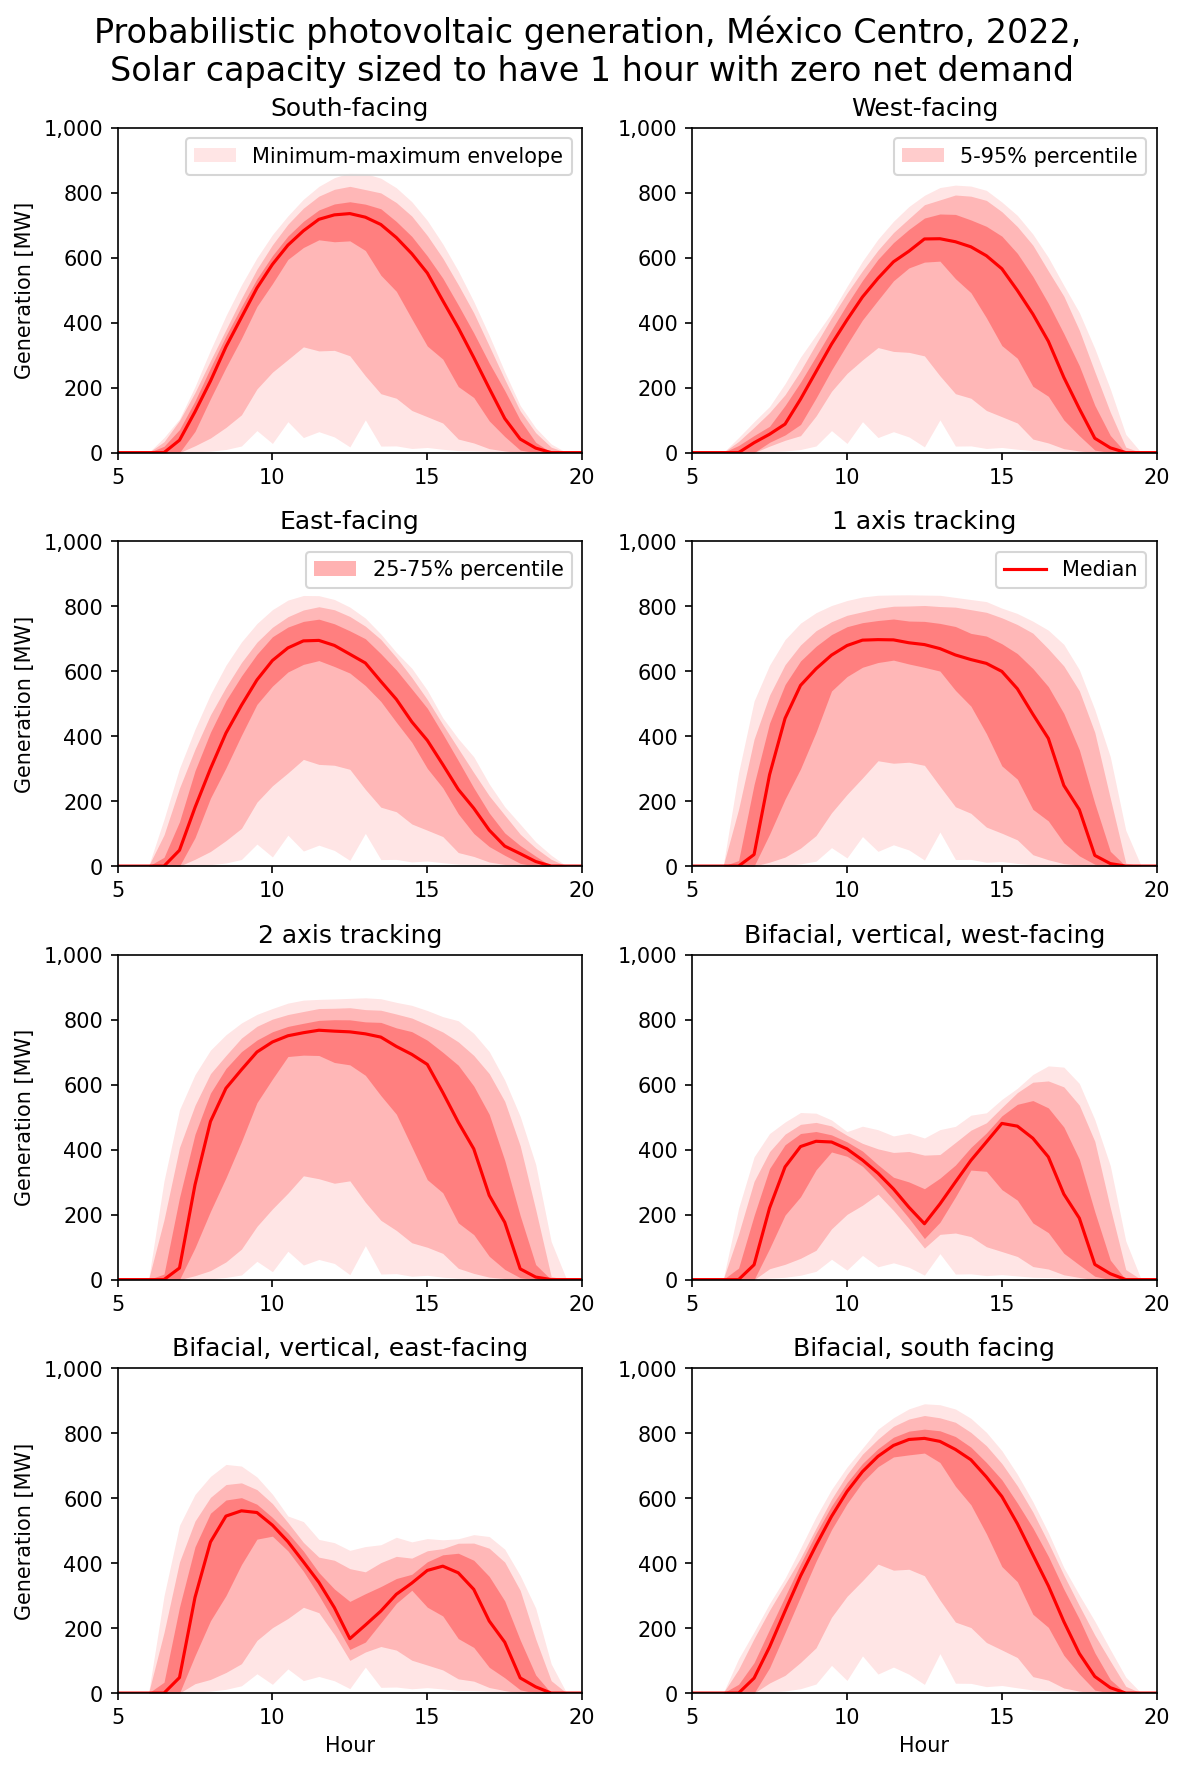

In [9]:
# Gráfica de producción fotovoltaica

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos los datos
    a = df[ ["hour", "dayofyear", prod_n[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n[i] )
    b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(5, 20)
    ax.set_ylim(0, 1000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Generation [kW/kWp]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle("Probabilistic photovoltaic generation, México Centro, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

In [10]:
# Cargamos la demanda

# Ruta de la demanda para México
path_f = "../data/Demanda/Mexico/Original/"

# Cargamos cada archivo
df_i = []
for f in os.listdir(path_f):
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        # Asignamos columnas
        df_0.columns = ['Sistema', 'Area', 'Hora', 'Generacion (MWh)',
           'Importacion Total (MWh)', 'Exportacion Total (MWh)',
            'Intercambio neto entre Gerencias (MWh)',
            'Estimacion de Demanda por Balance (MWh)']
        # Damos formato a la fecha
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 25, np.nan)
        df_0 = df_0.dropna()
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 24, 0)
        df_0["Date"] = pd.to_datetime( df_0["Hora"].apply(
            lambda x: f"{f[40:50]} {x:02.0f}:00:00" ) )
        
        df_i.append( df_0.set_index("Date") )

# Unimos todos los archivos
df_1 = pd.concat(df_i).set_index( ["Sistema", "Area"],
    append = True ).sort_index()

# Agregamos la demanda a la tabla de producción
demanda = "Estimacion de Demanda por Balance (MWh)"
df["Demand"] = df_1.loc[ (slice(None), "SIN", "CEN"), demanda
    ].reset_index(level = [1, 2], drop = True)
df["Demand"] = df["Demand"].interpolate("cubic")

df_1

Hora  Generacion (MWh)  \
Date                Sistema Area                            
2022-01-01 00:00:00 SIN     CEN   0 kWh         3,073 kWh   
                            NES   0 kWh         7,625 kWh   
                            NOR   0 kWh         3,275 kWh   
                            NTE   0 kWh         2,442 kWh   
                            OCC   0 kWh         3,691 kWh   
...                                 ...               ...   
2022-12-31 23:00:00 SIN     NOR  23 kWh         3,166 kWh   
                            NTE  23 kWh         2,840 kWh   
                            OCC  23 kWh         3,388 kWh   
                            ORI  23 kWh         5,345 kWh   
                            PEN  23 kWh         1,040 kWh   

                                  Importacion Total (MWh)  \
Date                Sistema Area                            
2022-01-01 00:00:00 SIN     CEN                     0 kWh   
                            NES                     0 kWh   
                            NOR                     0 kWh   
                            NTE                     0 kWh   
                            OCC                     0 kWh   
...                                                   ...   
2022-12-31 23:00:00 SIN     NOR                     0 kWh   
                            NTE                     0 kWh   
                            OCC                     0 kWh   
                            ORI                     0 kWh   
                            PEN                     0 kWh   

                                  Exportacion Total (MWh)  \
Date                Sistema Area                            
2022-01-01 00:00:00 SIN     CEN                     0 kWh   
                            NES                     1 kWh   
                            NOR                     0 kWh   
                            NTE                     0 kWh   
                            OCC                     0 kWh   
...                                                   ...   
2022-12-31 23:00:00 SIN     NOR                     0 kWh   
                            NTE                     0 kWh   
                            OCC                     0 kWh   
                            ORI                    27 kWh   
                            PEN                    21 kWh   

                                  Intercambio neto entre Gerencias (MWh)  \
Date                Sistema Area                                           
2022-01-01 00:00:00 SIN     CEN                                2,063 kWh   
                            NES                               -3,194 kWh   
                            NOR                               -1,418 kWh   
                            NTE                                 -145 kWh   
                            OCC                                2,165 kWh   
...                                                                  ...   
2022-12-31 23:00:00 SIN     NOR                               -1,105 kWh   
                            NTE                                 -426 kWh   
                            OCC                                2,908 kWh   
                            ORI                                   -1 kWh   
                            PEN                                  437 kWh   

                                  Estimacion de Demanda por Balance (MWh)  
Date                Sistema Area                                           
2022-01-01 00:00:00 SIN     CEN                                 5,135 kWh  
                            NES                                 4,430 kWh  
                            NOR                                 1,857 kWh  
                            NTE                                 2,297 kWh  
                            OCC                                 5,856 kWh  
...                                                                   ...  
2022-12-31 23:00:00 SIN     NOR                         

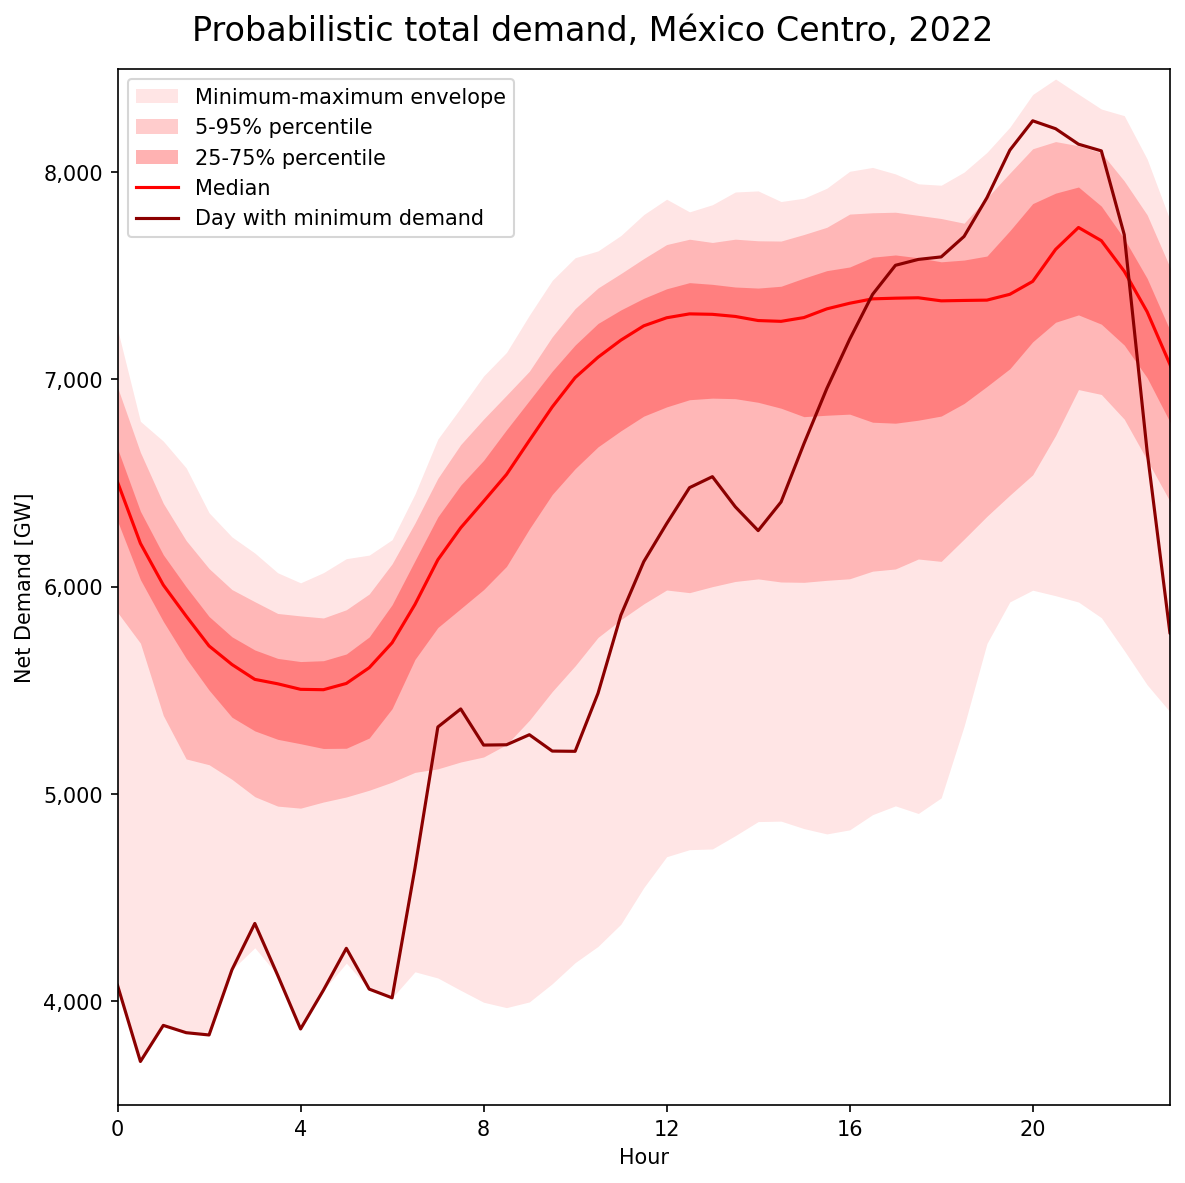

In [12]:
# Gráfica de demanda total

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Procesamos datos
a = df[ ["hour", "dayofyear", "Demand"]
    ].reset_index(drop = True).pivot( index = "hour",
    columns = "dayofyear", values = "Demand" )
b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

# Graficamos
ax.fill_between(b.index, b[1], b[0],
    color = "red", alpha = 0.1, linewidth = 0)
ax.fill_between(b.index, b[0.95], b[0.05],
    color = "red", alpha = 0.2, linewidth = 0)
ax.fill_between(b.index, b[0.75], b[0.25],
    color = "red", alpha = 0.3, linewidth = 0)
ax.plot(b.index, b[0.5], color = "red")
ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

# Formato de gráfica
ax.legend( ["Minimum-maximum envelope", "5-95% percentile",
    "25-75% percentile", "Median", "Day with minimum demand"] )
ax.set_xlim(0, 23)
ax.set_ylim(3500, 8500)
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Net Demand [GW]")
ax.set_xlabel("Hour")
fig.suptitle("Probabilistic total demand, México Centro, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

In [27]:
# Minimun capacity to reach zero net demand during duck's belly
# Función que determina la demanda mínima en términos de la capacidad
def demand(x, v): return np.nanmin(df[["Demand"]].values - df[[v]].values * x)
# Encontramos la capacidad que ocasiona una demanda nula
n = []
for v in prod_n: n.append( optimize.fsolve(demand, x0 = 5, args = (v))[0] )
# Resultados
print("Minimun capacity to reach zero net demand during duck's belly")
pd.options.display.float_format = "{:,.2f} GWp".format
cap = pd.Series( n, index = names_dn )
print( cap.sort_values( ascending = True ).to_string() )

# Energy produced using capacity that produces zero demand
df = df.copy()
# Net demand with capacity that produces zero demand
df[track_net_demand] = ( df[["Demand"]].values
    - df[prod_n].values * n ).copy()
prod_dn_min = [f"{x}_min" for x in track_net_demand]
# Net demand with same capacity for all cases
df[prod_dn_min] = ( df[["Demand"]].values
    - df[prod_n].values * np.min(n) )
print("\nEnergy produced using capacity that produces zero demand")
pd.options.display.float_format = "{:,.0f} MWh".format
ener = pd.Series( ( df[prod_n] * n / 2
    ).copy().sum().values, index = names_dn )
print( ener.sort_values(ascending = False).to_string() )

# Demand ramp
track_net_demand_dt = [ f"{x}_dt" for x in track_net_demand ]
df[track_net_demand_dt] = ( ( df[track_net_demand]
    - df[track_net_demand].shift(1) ) * 2)
df["Demand_dt"] = ( ( df["Demand"]
    - df["Demand"].shift(1) ) * 2).copy()

# Capacity factor
print( "\nCapacity factor" )
pd.options.display.float_format = "{:,.1f} %".format
cap_f = pd.Series( 100 * ener.values / ( 1000 * 24 * 365 * cap.values ),
    index = names_dn )
print( cap_f.sort_values(ascending = False).to_string() )

Minimun capacity to reach zero net demand during duck's belly
2 axis tracking                   5.34 GWp
Bifacial, south facing            5.89 GWp
South-facing                      6.11 GWp
1 axis tracking                   6.44 GWp
East-facing                       6.79 GWp
Bifacial, vertical, east-facing   6.91 GWp
West-facing                       7.41 GWp
Bifacial, vertical, west-facing   8.61 GWp

Energy produced using capacity that produces zero demand
1 axis tracking                   12,957,578 MWh
West-facing                       11,594,693 MWh
East-facing                       11,330,221 MWh
2 axis tracking                   11,322,189 MWh
Bifacial, south facing            11,298,497 MWh
Bifacial, vertical, west-facing   11,007,708 MWh
South-facing                      10,645,703 MWh
Bifacial, vertical, east-facing    9,200,324 MWh

Capacity factor
2 axis tracking                   24.2 %
1 axis tracking                   23.0 %
Bifacial, south facing            21.9 %
Sout

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/929090582.py:27: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/929090582.py:30: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_10695/929090582.py:33: MatplotlibDeprecationWarning: An artist whose label starts with an underscor

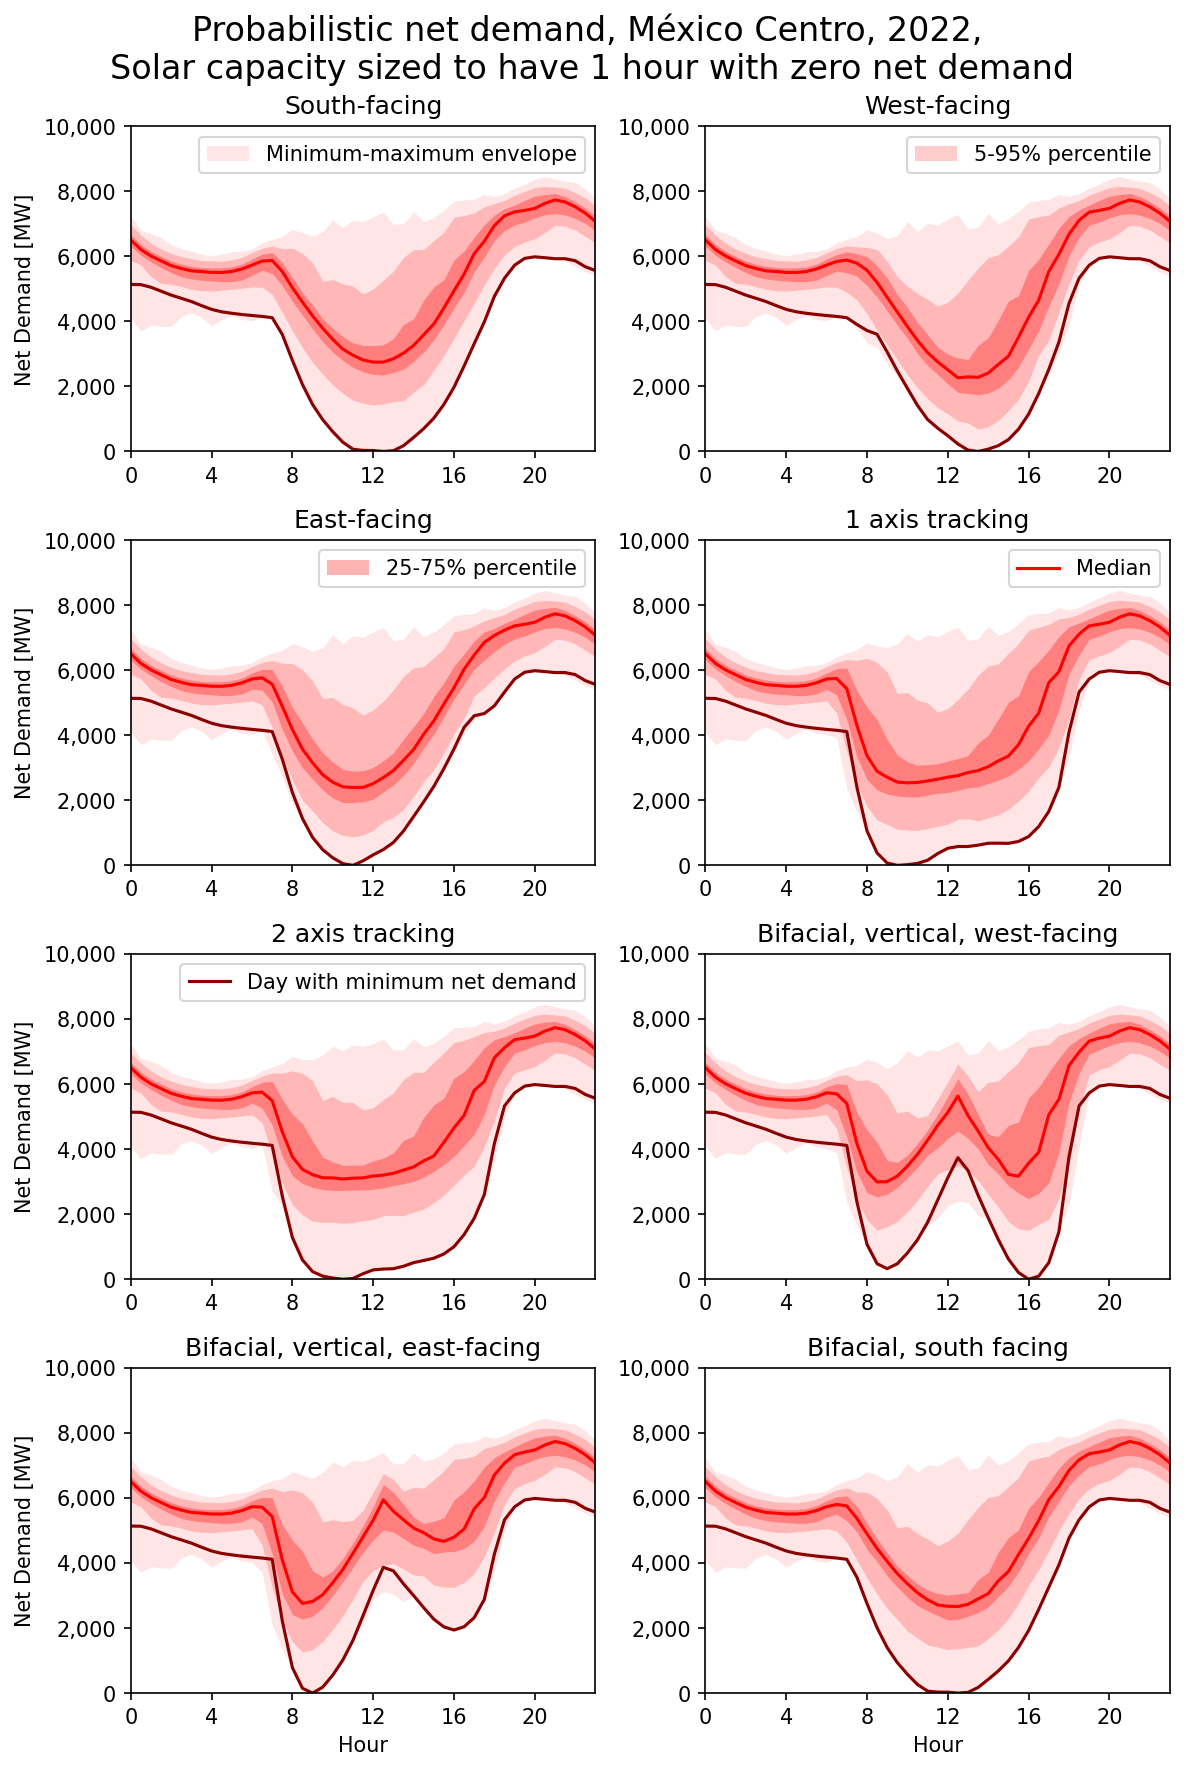

In [17]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    a = df[ ["hour", "dayofyear", track_net_demand[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[i] )
    b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 4:
        ax.legend( ["_", "_", "_", "_", "Day with minimum net demand"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [MW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle("Probabilistic net demand, México Centro, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

Maximum load
No PV                             8,449 MW
South-facing                      8,449 MW
West-facing                       8,449 MW
East-facing                       8,449 MW
1 axis tracking                   8,449 MW
2 axis tracking                   8,449 MW
Bifacial, vertical, west-facing   8,449 MW
Bifacial, vertical, east-facing   8,449 MW
Bifacial, south facing            8,449 MW

Minimum load
1 axis tracking                      20 MW
Bifacial, south facing               23 MW
South-facing                         24 MW
2 axis tracking                      37 MW
West-facing                          43 MW
Bifacial, vertical, west-facing      91 MW
East-facing                         140 MW
Bifacial, vertical, east-facing     147 MW
No PV                             3,710 MW


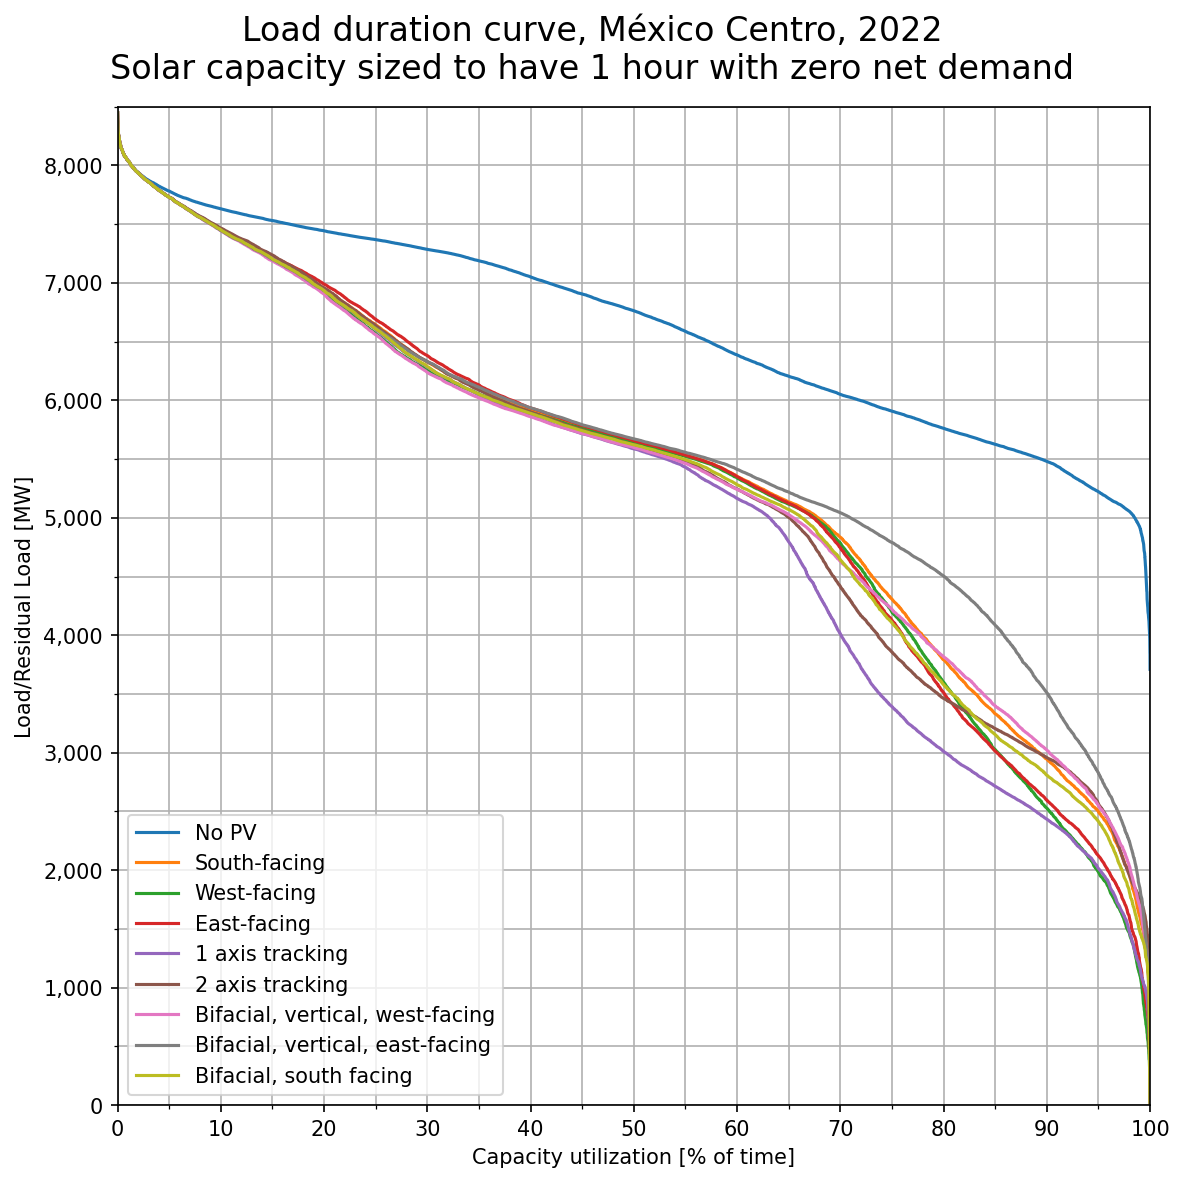

In [18]:
# Load duration curve

# Demandas máxima y mínima
b = df[["Demand"] + track_net_demand].max(axis = 0)
b.index = ["No PV"] + names_dn
pd.options.display.float_format = '{:,.0f} MW'.format
print("Maximum load")
print( b.sort_values().to_string() )
print()
print("Minimum load")
b = df[["Demand"] + track_net_demand]
b = b.where(b>0, np.nan).dropna().min(axis = 0)
b.index = ["No PV"] + names_dn
print( b.sort_values().to_string() )

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn )
ax.set_xlim(0, 100)
ax.set_ylim(0, 8500)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.yaxis.set_minor_locator(plt.MultipleLocator(500))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Load/Residual Load [MW]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle("Load duration curve, México Centro, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

Maximum ramp
No PV                             3,069 MW/h
Bifacial, vertical, east-facing   7,666 MW/h
2 axis tracking                   8,405 MW/h
East-facing                       8,511 MW/h
1 axis tracking                   8,650 MW/h
Bifacial, south facing            9,132 MW/h
South-facing                      9,206 MW/h
Bifacial, vertical, west-facing   9,423 MW/h
West-facing                       9,825 MW/h


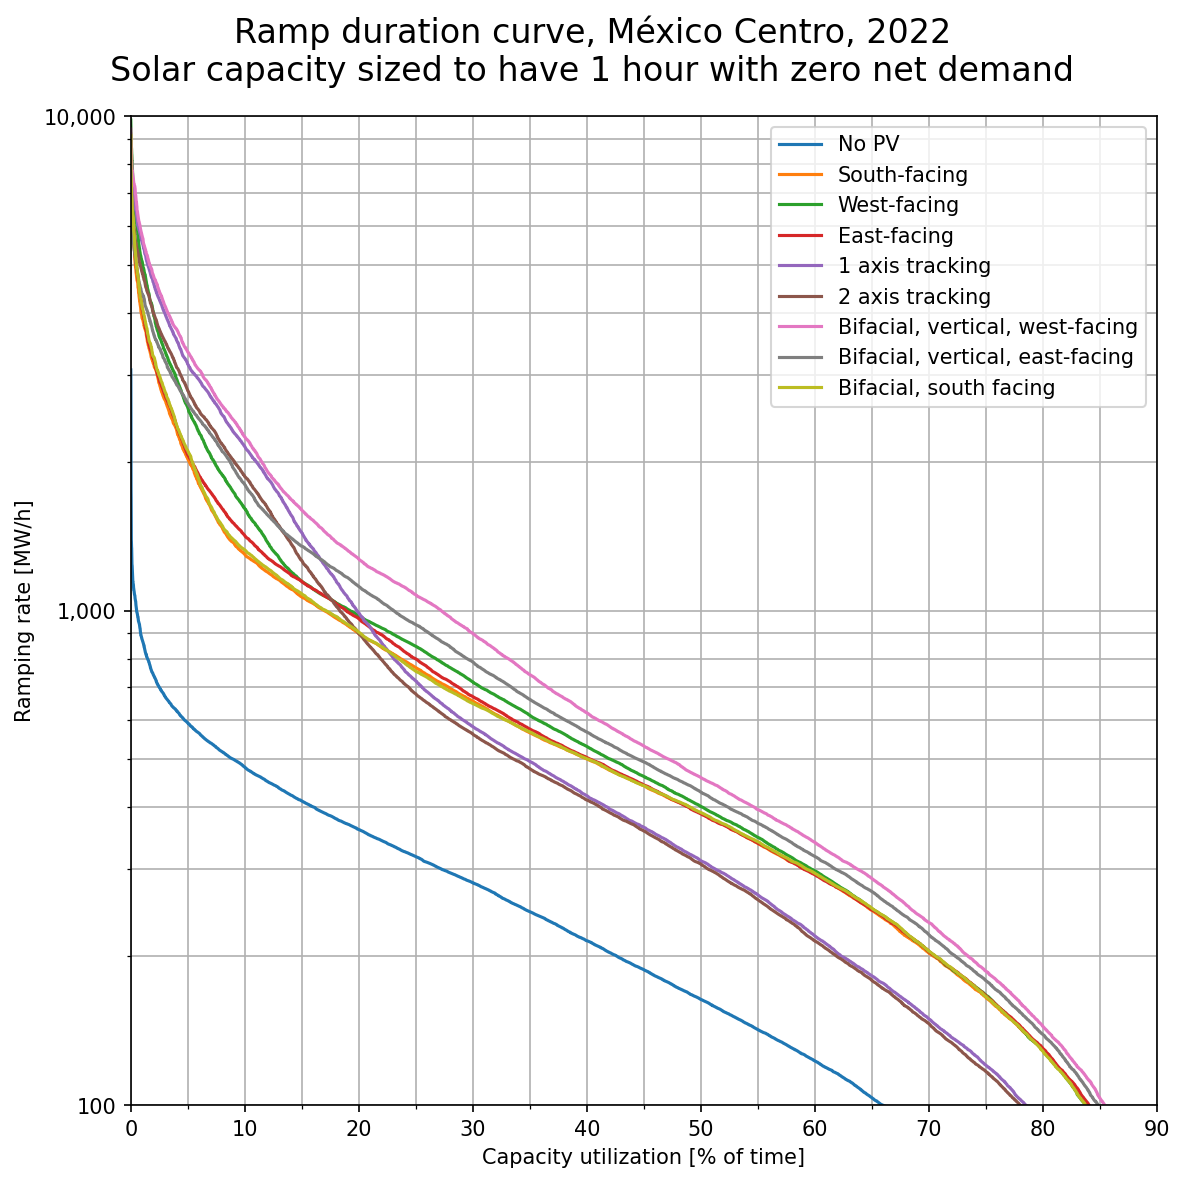

In [19]:
# Rampa máxima
b = np.abs( df[["Demand_dt"] + track_net_demand_dt] ).max(axis = 0)
b.index = ["No PV"] + names_dn
pd.options.display.float_format = '{:,.0f} MW/h'.format
print("Maximum ramp")
print( b.sort_values().to_string() )

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand_dt"] + track_net_demand_dt:
    a = np.abs(df[[v]]).sort_values( v,
        ascending = False ).reset_index(drop = True)
    a = a.where(a>0, 0)
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn )
ax.set_yscale("log")
ax.set_xlim(0, 90)
ax.set_ylim(100, 10000)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Ramping rate [MW/h]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle("Ramp duration curve, México Centro, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()